# Yield Curve Flies

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Get Data

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/CashTreasuries/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CashTreasuries\root\src")
from SyntheticFlys import CTDFly

## Duration Exposure

First check the duration exposure on a comparison basis

In [3]:
def get_duration() -> pd.DataFrame: 
    
    df_dur = (CTDFly().get_flies().query(
        "variable == 'duration'").
        drop(columns = ["variable"]).
        melt(id_vars = ["date", "fly"]).
        assign(
            var = lambda x: x.pos.str.split("_").str[0],
            pos = lambda x: x.pos.str.split("_").str[1]).
        pivot(index = ["date", "fly", "var"], columns = "pos", values = "value").
        assign(weighted_rtn = lambda x: x.weight * x.val).
        reset_index().
        pivot(index = ["date", "fly"], columns = "var", values = "weighted_rtn").
        reset_index())
    
    return df_dur

df_duration = get_duration()

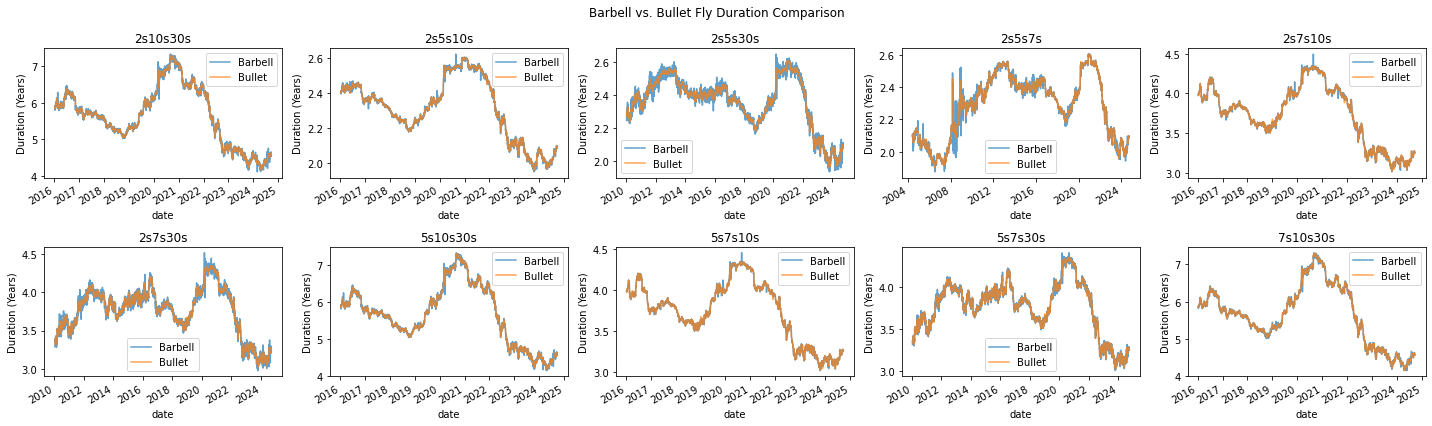

In [4]:
def plot_duration_comparison(df_duration: pd.DataFrame) -> plt.Figure: 
    
    flys      = df_duration.fly.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(flys) // 2, nrows = len(flys) // 5, figsize = (20,6))

    for fly, ax in zip(flys, axes.flatten()): 

        (df_duration.query(
            "fly == @fly").
            drop(columns = ["fly"]).
            assign(Barbell = lambda x: x.long + x.short).
            melt(id_vars = "date").
            rename(columns = {"var": ""}).
            pivot(index = "date", columns = "", values = "value")
            [["Barbell", "bullet"]].
            rename(columns = {"bullet": "Bullet"}).
            plot(
                alpha  = 0.7,
                ylabel = "Duration (Years)",
                title  = fly,
                ax     = ax))

    fig.suptitle("Barbell vs. Bullet Fly Duration Comparison")
    plt.tight_layout()
    
plot_duration_comparison(df_duration)

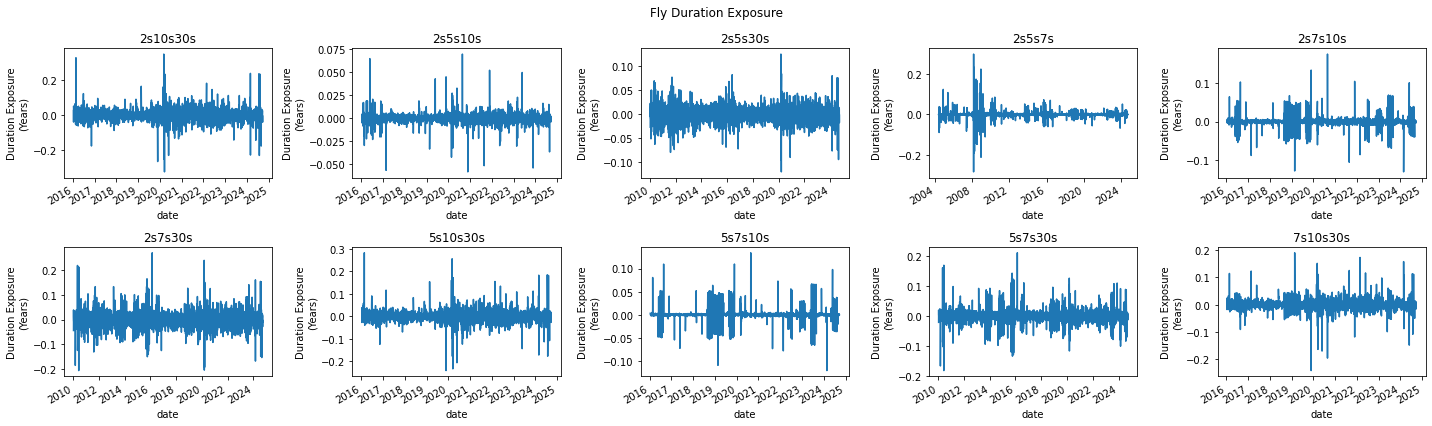

In [5]:
def plot_duration_exposure(df_duration: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_duration.assign(
        duration_exposure = lambda x: (x.long + x.short) - x.bullet))

    flys      = df_duration.fly.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(flys) // 2, nrows = len(flys) // 5, figsize = (20,6))

    for fly, ax in zip(flys, axes.flatten()):

        (df_tmp.query(
            "fly == @fly").
            set_index("date")
            [["duration_exposure"]].
            plot(
                ax     = ax,
                legend = False,
                title  = fly,
                ylabel = "Duration Exposure\n(Years)"))

    fig.suptitle("Fly Duration Exposure")
    plt.tight_layout()
    
plot_duration_exposure(df_duration)

## Fly Return

In [6]:
def get_rtn() -> pd.DataFrame: 
    
    df_rtn = (CTDFly().get_flies().query(
        "variable == 'bnd_rtn'").
        drop(columns = ["variable"]).
        melt(id_vars = ["date", "fly"]).
        assign(
            var = lambda x: x.pos.str.split("_").str[0],
            pos = lambda x: x.pos.str.split("_").str[1]).
        pivot(index = ["date", "fly", "var"], columns = "pos", values = "value").
        assign(weighted_val = lambda x: x.weight * x.val).
        reset_index().
        pivot(index = ["date", "fly"], columns = "var", values = "weighted_val").
        assign(Barbell = lambda x: x.long + x.short).
        rename(columns = {"bullet": "Bullet"})
        [["Bullet", "Barbell"]].
        reset_index())
    
    return df_rtn

df_rtn = get_rtn()

Plot out return legs

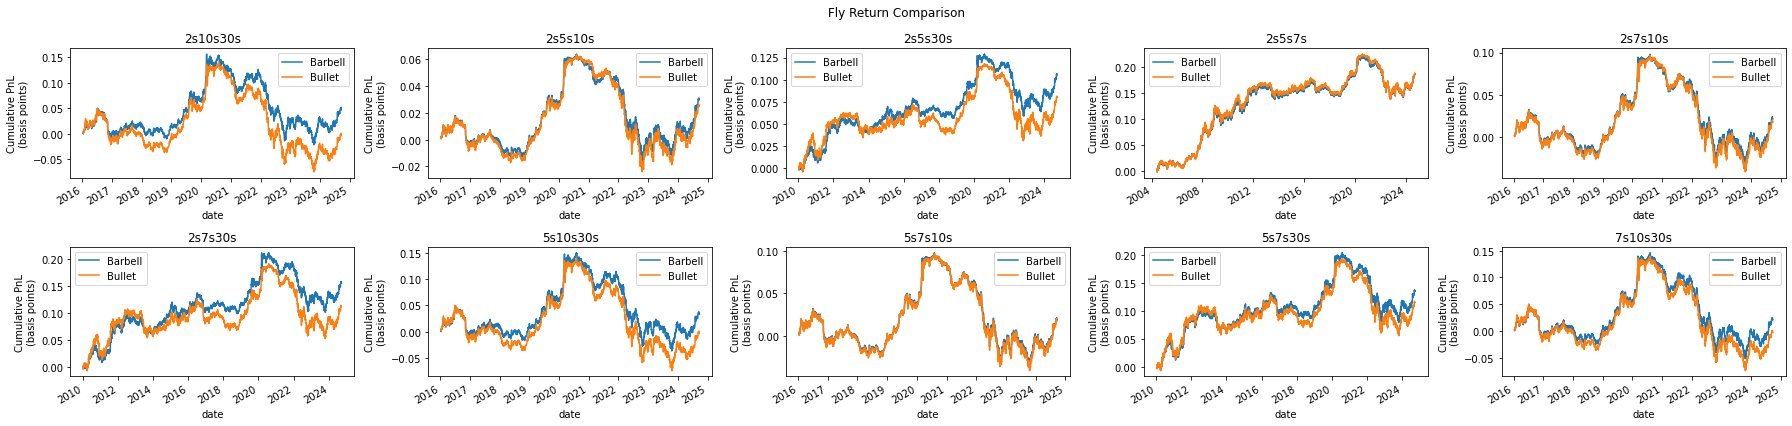

In [7]:
def plot_fly_rtn_comparison(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    flys      = df_rtn.fly.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(flys) // 2, nrows = len(flys) // 5, figsize = (25,6))

    for fly, ax in zip(flys, axes.flatten()):

        (df_rtn.query(
            "fly == @fly").
            drop(columns = ["fly"]).
            melt(id_vars = "date").
            rename(columns = {"var": ""}).
            pivot(index = "date", columns = "", values = "value").
            cumsum().
            plot(
                ylabel = "Cumulative PnL\n(basis points)",
                title  = fly,
                ax     = ax))

    fig.suptitle("Fly Return Comparison")
    plt.tight_layout()
    
plot_fly_rtn_comparison(df_rtn)

Now calculate the return and plot it

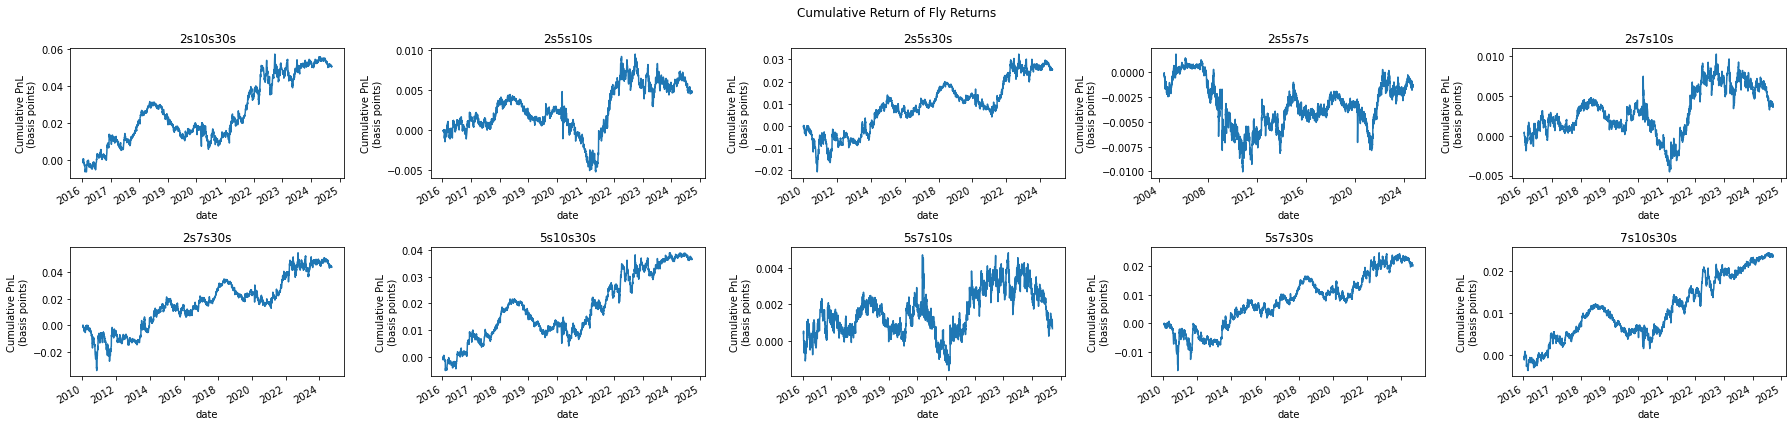

In [8]:
def plot_fly_rtn(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_rtn.assign(
        fly_rtn = lambda x: x.Barbell - x.Bullet))

    flys      = df_tmp.fly.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(flys) // 2, nrows = len(flys) // 5, figsize = (25,6))

    for fly, ax in zip(flys, axes.flatten()):

        (df_tmp.query(
            "fly == @fly").
            set_index("date")
            [["fly_rtn"]].
            cumsum().
            plot(
                legend = False,
                ylabel = "Cumulative PnL\n(basis points)",
                title  = fly, 
                ax     = ax))

    fig.suptitle("Cumulative Return of Fly Returns")
    plt.tight_layout()
    
plot_fly_rtn(df_rtn)